# Analyzing global radiation data from MeteoSwiss via swisstopo's STAC API

## Overview
This notebook demonstrates how to:
- Download CSV data from MeteoSwiss' Open Government Data (OGD) via swisstopo's STAC API.
- Handle potential errors during data retrieval.
- Process global radiation values. A description of available parameters can be found here [`ogd-smn_meta_parameters.csv`](https://data.geo.admin.ch/ch.meteoschweiz.ogd-smn/ogd-smn_meta_parameters.csv):
- Plot monthly mean global radiation [W/m^2] (parameter `gre000m0`) at the station HAI


## Data Sources
- [ogd-smn_hai_m_historical.csv](https://data.geo.admin.ch/ch.meteoschweiz.ogd-smn/hai/ogd-smn_hai_m.csv)
- [ogd-smn_hai_m_recent.csv](https://data.geo.admin.ch/ch.meteoschweiz.ogd-smn/hai/ogd-smn_hai_m.csv)
  

## Sources of problems
- Colum names sometimes contain quptes `'`, that need to be removed first
- inconsistend column names between the `_historical` and `_recent` files, i.e. `reference_timestamp` vs. `REFERENCE_TS`
  

## Prerequesites
In order to run this Jupyter notebook, you need the following packages installed on your machine
- Jupyter, quite obvious ;-)
- Python
- pandas
- matplotlib
- seaborn


## STAC API

### Documentation
For documentation please refer to [swisstopo's STAC API documentation](https://data.geo.admin.ch/api/stac/static/spec/v1/api.html).

### How to check for new data
When downloading data from the STAC API, you might want to make sure to always retrive the most current data.<br>
By default, asset objects are cached for 2 hours. But there might be objects, that are updated more frequently.<br>
We highly recommend to use preconditioning via the `If-Match` or `If-None-Match` headers (mostly the latter one) when making calls to the STAC API.<br>
This reduces unnecessary traffic. When the client sends an `If-None-Match` header containing the `ETag` of the current (local) <br>version of the requested object, the server compares it to the currently available resource's `ETag` on the server.<br>
Only in case the two values don't match, the requested object is sent. <br>
Otherwise the server responds with a `304 Not Modified` without a body, which tells the user (i.e. the client) that his version of the asset is still good to use.<br>
For more details please check [swisstopo's STAC API documentation](https://data.geo.admin.ch/api/stac/static/spec/v1/apitransactional.html#tag/Data/operation/getAssetObject).

## Disclaimer
This notebook is intended to be a brief demonstration, hence the code used here is not optimized for production use.

---

In [ ]:
# Import necessary libraries
import pandas as pd  # Data processing: https://pandas.pydata.org/docs/
import matplotlib.pyplot as plt  # Visualization: https://matplotlib.org/stable/contents.html
import seaborn as sns  # Also used for visualization: https://seaborn.pydata.org/


# Define file URLs
historical_url = "https://data.geo.admin.ch/ch.meteoschweiz.ogd-smn/hai/ogd-smn_hai_m.csv"
recent_url = "https://data.geo.admin.ch/ch.meteoschweiz.ogd-smn/hai/ogd-smn_hai_m.csv"

# define the parameter we want to use
globrad_col = "gre000m0"

# define time range we want to analyse
# for our example we want to compare the months september to december of the years 2023 and 2024
start_year = 2023
end_year = 2024

start_month = 9
end_month = 12


def download_csv(url):
    """
    Downloads a CSV file from a given URL and returns a Pandas DataFrame.
    """
    try:
        # in production, please check if a local copy of the files already exists. If so, please
        # send the ETag of the local resource (that you got in the response when initially
        # requesting the resource) in an If-None-Match header. The server will only send the file,
        # if the remote version is newer than your local file. This avoids unnecessary traffic.
        # (also check here: https://data.geo.admin.ch/api/stac/static/spec/v1/apitransactional.html#tag/Data/operation/getAssetObject)
        # For our short example, we don't need to do 4all this.
        df = pd.read_csv(url, delimiter=';')
        return df
    # too broad exception, I know. Please use better error handling in production ;-)
    except Exception as e:
        print(f"Error downloading {url}: {e}")
        return None


Once we have defined some initial parameters and the function for downloading the csv files from the STAC API, we need to define a function for sanitizing the column names of our pandas dataframes.<br>
This is necessary, since some of the column names of the raw data contain `'`. Additionally, we make sure, that we use the same name for the column which contains the timestamp, since in the raw data files the name varies.

In [60]:
def sanitize_column_names(df):
    """
    Removes single quotes from column names in a given Pandas DataFrame.
    Also rename "REFERENCE_TS" to "reference_timestamp".

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: A new DataFrame with cleaned column names.
    """
    new_column_names = {col: col.replace("'", "") for col in df.columns}
    df_cleaned = df.rename(columns=new_column_names)

    if "REFERENCE_TS" in df_cleaned.columns:
        df_cleaned = df_cleaned.rename(columns={"REFERENCE_TS": "reference_timestamp"})

    if not globrad_col in df_cleaned.columns:
        print("Error: No valid global radiation column found!")
        return None


    return df_cleaned

Now we call the functions we have defined above

In [61]:
df_recent = download_csv(recent_url)
df_historical = download_csv(historical_url)

# sanitize column names
df_recent = sanitize_column_names(df_recent)
df_historical = sanitize_column_names(df_historical)


Now that we downloaded the files, we can process the data.
We need to concatenate the two dataframes from the two files we use, the `_historical` and the `_recent` ones.<br>
We also drop potential duplicates and filter the data according to our desired years and months we want to study (defined above).

In [62]:
def process_data(df_recent, df_historical):
    """
    Process the data, i,e, concatenate the two data frames from the _historical and the _recent files.
    Also drop potential duplicates and only return data in the defined time range we want to analyse.

    Args:
        df_recent, df_historical (pd.DataFrame): The input DataFrames.

    Returns:
        pd.DataFrame: A new DataFrame with processed data.
    """


    # concatenate the two data frames of the historical and the recent data into one single data frame
    df = pd.concat([df_historical[['reference_timestamp', globrad_col]], df_recent[['reference_timestamp', globrad_col]]], ignore_index=True)
    # remove duplicates (there should be no duplicates, but just in case...)
    df = df.drop_duplicates(ignore_index=True)

    df["timestamp"] = pd.to_datetime(df["reference_timestamp"], format="%d.%m.%Y %H:%M", errors="raise")
    df["year"] = df["timestamp"].dt.year
    df["month"] = df["timestamp"].dt.month
    df["month_str"] = df["timestamp"].dt.strftime("%B")


    df = df[df["month"].between(start_month, end_month) & df["year"].between(start_year, end_year)]


    return df


df = process_data(df_recent, df_historical)


## Visualization
Now wa are ready to plot the monthly mean global radiation from Sept - Dec for 2023 and 2024

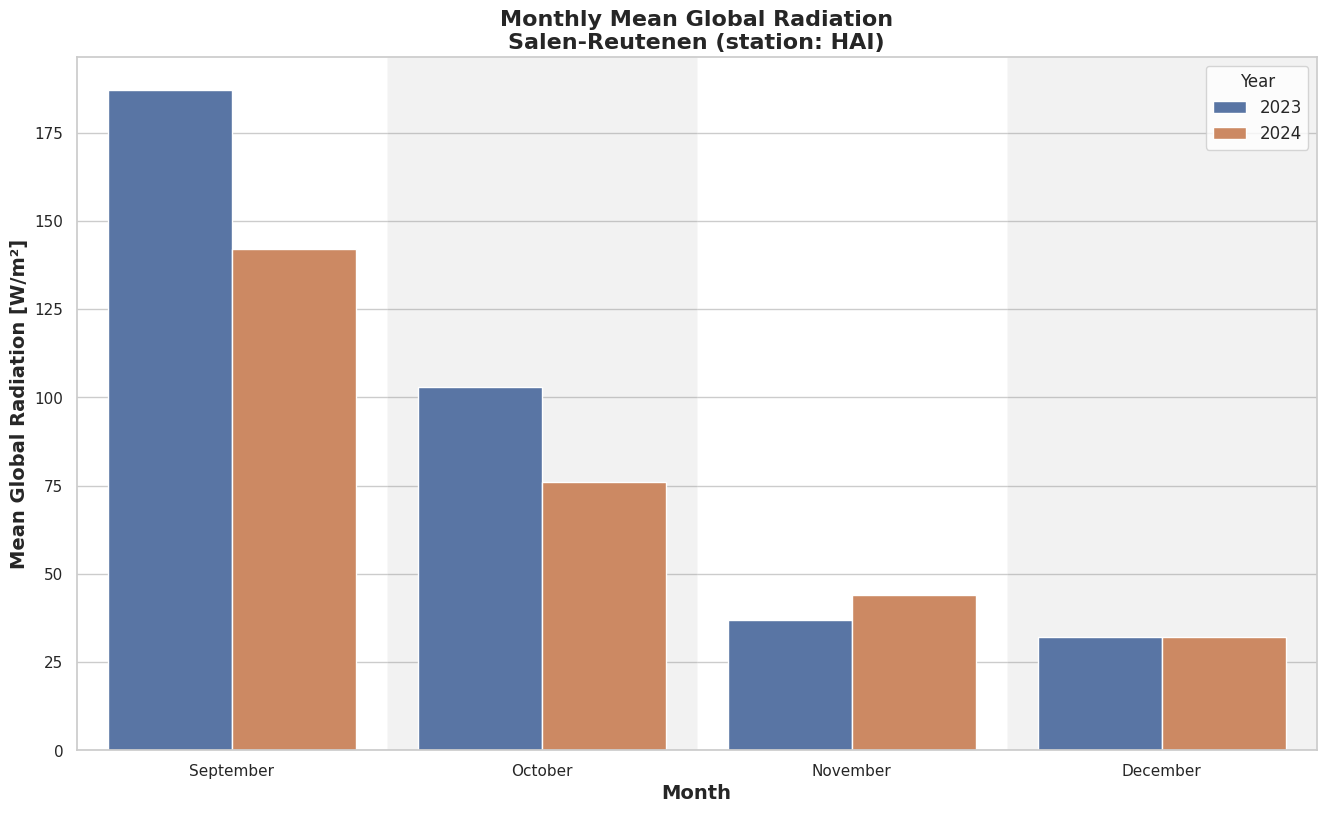

In [63]:
def create_plot(df):
    """
    Plots global radiation monthly means
    """

    sns.set_theme(style="whitegrid")
    color_palette = sns.color_palette("deep", len(df["year"].unique()))

    plt.figure(figsize=(16, 9))
    ax = plt.gca()

    # Shading every 2nd Month for better readability.
    # Might need to be adapted for incomplete timeseries, or years with gaps, but works nice for our example
    for i in range(1, len(df["month_str"].unique()), 2):
        ax.axvspan(i - 0.5, i + 0.5, facecolor='gray', alpha=0.1)

    sns.barplot(data=df, x="month_str", y="gre000m0", hue="year", dodge=True, ax=ax, palette=color_palette)
    ax.set_xlabel("Month", fontsize=14, fontweight='bold')
    ax.set_ylabel("Mean Global Radiation [W/m²]", fontsize=14, fontweight='bold')
    ax.set_title("Monthly Mean Global Radiation\nSalen-Reutenen (station: HAI)", fontsize=16, fontweight='bold')

    ax.legend(title="Year", fontsize=12)

    plt.show()

create_plot(df)
